# Song Recommendation System with Surprise
#### author: Anna Dąbkowska

### Description:
* User-based collaborative filtering approach
* data from Yahoo! Webscope http://webscope.sandbox.yahoo.com (R2 - Yahoo! Music User Ratings of Songs with Artist, Album, and Genre Meta Information, v. 1.0)

#### Project includes:
__1. Data preprocessing__
<br>__2. Model training (SVD and kNN Baseline) and parameter tuning__
<br>__3. Model performance visualization__
<br>__4. Song recommender__
<br>__5. Operations on similiar users (SVD) and neighbours (kNN)__
<br>__6. Music genres graph__

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
from pyvis.network import Network

from surprise import dataset, Dataset, Reader, KNNBaseline, SVD, accuracy
from surprise.model_selection import cross_validate, GridSearchCV

from scipy.spatial import distance

## I. Data preprocessing

#### 1. Loading data (train, test, songs, genres)
*Train data*

In [2]:
data=pd.read_csv('train_0.txt',sep='\t',header=None)
data.columns=['user_id','song_id','rating']
data.head(3)

,user_id,song_id,rating
0,0,166,5
1,0,2245,4
2,0,3637,4


In [3]:
print('There are',data['user_id'].nunique(),'users and',data['song_id'].nunique(),'songs in the dataset.')

There are 200000 users and 136736 songs in the dataset.


*Test data*

In [4]:
data_test=pd.read_csv('test_0.txt',sep='\t',header=None)
data_test.columns=['user_id','song_id','rating']
data_test.head(3)

,user_id,song_id,rating
0,0,7171,5
1,0,8637,4
2,0,21966,4


In [5]:
data_test.groupby('user_id').count()

,song_id,rating
user_id,,
0,10,10
1,10,10
2,10,10
3,10,10
4,10,10
...,...,...
199995,10,10
199996,10,10
199997,10,10


*Genres*

In [6]:
data_genres=pd.read_csv('genre-hierarchy.txt',sep='\t',header=None)
data_genres.columns=['genre_id','parent_genre_id','level','genre_name']
data_genres.set_index('genre_id',inplace=True)
data_genres.head()

,parent_genre_id,level,genre_name
genre_id,,,
0,0,1,Unknown
1,1,1,Electronic/Dance
2,1,2,Ambient
3,2,3,Ambient Dub
4,2,3,Ambient Tech


In [7]:
print('Highest level in hierarchy tree (root): ',min(data_genres['level']))
print('Lowest level in hierarchy tree: ',max(data_genres['level']))

Highest level in hierarchy tree (root):  1
Lowest level in hierarchy tree:  3


*Songs*

In [8]:
data_songs=pd.read_csv('song-attributes.txt',sep='\t',header=None)
data_songs.columns=['song_id','album_id','artist_id','genre_id']
data_songs.set_index('song_id',inplace=True)
data_songs.head(3)

,album_id,artist_id,genre_id
song_id,,,
0,12070,8490,0
1,19512,7975,134
2,18953,3492,0


#### 2. Preparing data for usage in models

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76344627 entries, 0 to 76344626
Data columns (total 3 columns):
 #   Column   Dtype
---  ------   -----
 0   user_id  int64
 1   song_id  int64
 2   rating   int64
dtypes: int64(3)
memory usage: 1.7 GB


Since surprise package isn't handling too well big sets of data (here train data consists of 76 344 627 rows), it will be cut.

In [10]:
data2=data[:300000].copy()

In [11]:
print('After sampling the train data is left with:')
print('Nr of rows:   300000','\nNr of users: ',data2['user_id'].nunique(),'\nNr of songs: ',data2['song_id'].nunique())

After sampling the train data is left with:
Nr of rows:   300000 
Nr of users:  745 
Nr of songs:  86950


Test data will be sampled to match the amount of users that are in the cut dataset (data2).
<br>Test data is sorted in a following manner: rows nr [10n,10(n+1)-1] contain the user_id=n (n=0,1,2,...), song_id and rating score of that user for that song; <br>that makes it easy to cut the test data, knowing that the train data is sorted with regards to user ids as well and there are 745 unique users in the cut train data (data2).

In [12]:
data_test2=data_test[:7450].copy()
data_test2.head(3)

,user_id,song_id,rating
0,0,7171,5
1,0,8637,4
2,0,21966,4


Checking which songs from the test set aren't present in the train set and deleting rows from test set if so (since song_id is the only information provided (to the model) about the items, model's predictions for songs outside of the train data would be pointless).
<br>*Note: a song in a test set is given ratings from different users than in the train set.*

In [13]:
s_to_remove=[song for song in list(data_test2['song_id'].unique()) if song not in list(data2['song_id'].unique())]

data_test2.drop([data_test2[data_test2['song_id']==i].index[0] for i in s_to_remove],inplace=True)

#### Quick exploratory data analysis

In [14]:
df_info=pd.merge(data_songs,data_genres,on=['genre_id'])
df_info.drop(columns=['album_id','artist_id','parent_genre_id','level','genre_id'],inplace=True)
df_info.reset_index(inplace=True)
df_info.columns=['song_id','genre_name']
df_info.head(3)

,song_id,genre_name
0,0,Unknown
1,1,Unknown
2,2,Unknown


In [15]:
data3=data2.merge(df_info,on='song_id')
data3.head(3)

,user_id,song_id,rating,genre_name
0,0,166,5,Unknown
1,0,2245,4,Unknown
2,6,2245,5,Unknown


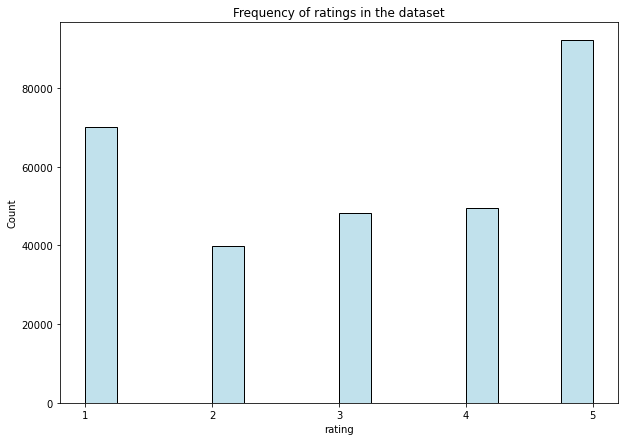

In [16]:
fig,ax=plt.subplots(figsize=(10,7))
sns.histplot(data3['rating'],color='lightblue',binwidth=.25, )
ax.set_xticks([1,2,3,4,5])
plt.title('Frequency of ratings in the dataset')
plt.show()

It's a bit dysproportional, but rather not as much to cause problems

In [17]:
print('5 most rated songs')
most5=data3.groupby('song_id').count()['user_id'].sort_values(ascending=False)[:5]
most5=most5.reset_index()
most5.columns=['song_id','times rated']
most5=pd.merge(most5,df_info,on='song_id')
most5

5 most rated songs


,song_id,times rated,genre_name
0,105433,151,Unknown
1,123176,135,Rock
2,22763,131,Unknown
3,8063,128,Unknown
4,72309,124,Unknown


In [18]:
print('5 most rated genres:')
data3.groupby('genre_name').count()['user_id'].sort_values(ascending=False)[:5]

5 most rated genres:


genre_name
Unknown    259123
Rock        16211
Pop          6797
R&B          5015
Country      2614
Name: user_id, dtype: int64

Due to the imbalance, rows with songs belonging to unknown genres will be dropped (only for visualization)

In [19]:
data3=data3.drop(data3[data3['genre_name']=='Unknown'].index)
data3['genre_name']=pd.Categorical(data3['genre_name'],list(data3.groupby('genre_name').count()['rating'].sort_values(ascending=False).index))

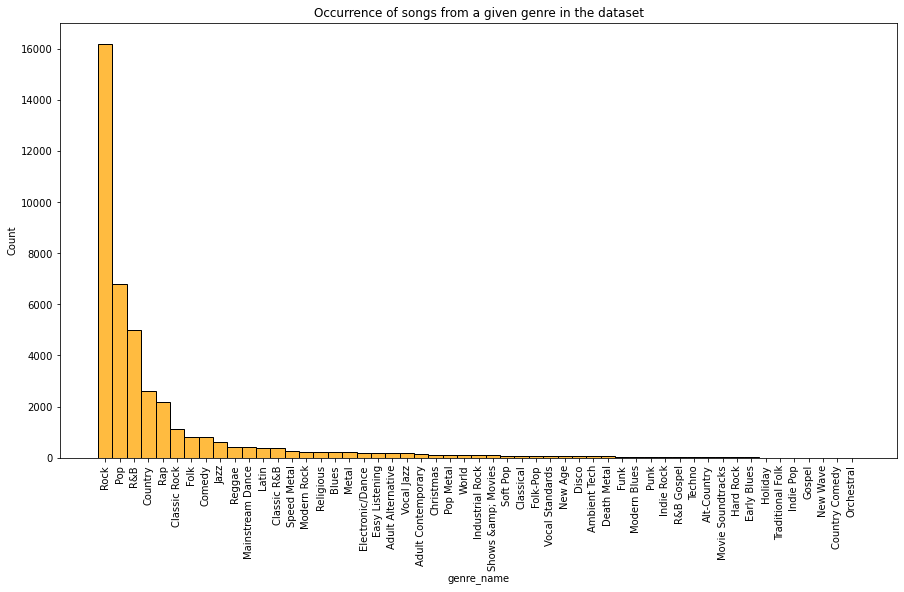

In [20]:
fig,ax=plt.subplots(figsize=(15,8))
sns.histplot(data3['genre_name'],color='orange')
plt.xticks(rotation=90)
plt.title('Occurrence of songs from a given genre in the dataset')
plt.show()

Preparing the data solely for the surprise package

In [21]:
reader = Reader(line_format='user item rating', rating_scale=(1, 5))

In [22]:
class DatasetTr(dataset.DatasetAutoFolds):
    def __init__(self, df, reader):
        self.raw_ratings = [(uid, iid, r, None) for (uid, iid, r) in
                            zip(df['user_id'], df['song_id'], df['rating'])]
        self.reader=reader

In [23]:
algdata=DatasetTr(data2,reader)

## II. Model training

### 1. SVD
The predicted rating $\hat{r}_{ui}$ of item $i$ by user $u$ is set as:
$$\hat{r}_{ui} = \mu + b_u + b_i + q_i^Tp_u$$
<br>where $\mu$ is the mean of all ratings,
<br>$\begin{split}b_u &\leftarrow b_u &+ \gamma (e_{ui} - \lambda b_u)\\
b_i &\leftarrow b_i &+ \gamma (e_{ui} - \lambda b_i)\\
p_u &\leftarrow p_u &+ \gamma (e_{ui} \cdot q_i - \lambda p_u)\\
q_i &\leftarrow q_i &+ \gamma (e_{ui} \cdot p_u - \lambda q_i)\end{split}$
<br>$e_{ui} = r_{ui} - \hat{r}_{ui}$

#### i. Cross validation approach
<br>Test data is sampled from the training data

In [24]:
svd = SVD()
cross_validate(svd, algdata, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.2968  1.2777  1.2853  1.2906  1.2959  1.2893  0.0071  
MAE (testset)     1.0329  1.0202  1.0258  1.0290  1.0343  1.0284  0.0051  
Fit time          10.00   9.97    10.18   9.95    9.99    10.02   0.08    
Test time         0.43    0.31    0.41    0.41    0.41    0.39    0.04    


{'test_rmse': array([1.29675803, 1.27774589, 1.28534123, 1.29060712, 1.29587056]),
 'test_mae': array([1.03291951, 1.02018196, 1.02580861, 1.02897953, 1.03429755]),
 'fit_time': (9.998781681060791,
  9.968886852264404,
  10.18325686454773,
  9.952693462371826,
  9.99449348449707),
 'test_time': (0.4253392219543457,
  0.31105732917785645,
  0.40946459770202637,
  0.4063088893890381,
  0.40756702423095703)}

#### ii. Using provided test data

In [25]:
trainset_model_surprise = Dataset.load_from_df(data2, reader).build_full_trainset()
testset_model_surprise = Dataset.load_from_df(data_test2, reader).build_full_trainset()
testset = testset_model_surprise.build_testset()

In [26]:
svd2 = SVD()
svd2.fit(trainset_model_surprise)
# predicting for (user, song) pairs that are in the test set
predictions = svd2.test(testset)

In [27]:
result = pd.DataFrame(predictions, columns=['user_id', 'song_id', 'real_rating', 'predicted_rating', 'details'])
result['error'] = abs(result['real_rating'] - result['predicted_rating'])
result.head()

,user_id,song_id,real_rating,predicted_rating,details,error
0,0,7171,5.0,4.220941,{'was_impossible': False},0.779059
1,0,8637,4.0,4.209725,{'was_impossible': False},0.209725
2,0,21966,4.0,4.135980,{'was_impossible': False},0.135980
3,0,90409,5.0,4.438259,{'was_impossible': False},0.561741
4,0,107410,5.0,4.252025,{'was_impossible': False},0.747975


In [28]:
accuracy.rmse(predictions, verbose=True)

RMSE: 1.2753


1.2753427794906793

### 2. k-NN Baseline model

The prediction $\hat{r}_{ui}$ of user's $u$ rating of a song $i$ is equal to:
$$\hat{r}_{ui} = b_{ui} + \frac{ \sum\limits_{v \in N^k_i(u)}
\text{sim}(u, v) \cdot (r_{vi} - b_{vi})} {\sum\limits_{v \in
N^k_i(u)} \text{sim}(u, v)}$$
where 
<br> $b_{ui},b_{vi}$ are baselines of song $i$ for users $u$ and $v$,
<br>$N^k_i(u)$ is a set of k or less neighbours of user $u$ that have rated song $i$,
<br> $\text{sim}(u, v)$ is a similarity measure between user $u$ and neighbour $v$,
<br> $r_{vi}$ is a true rating of a song $i$ given by neighbour $v$

#### i. Cross validation approach
<br>Test data is sampled from the training data

In [29]:
sim_options = {'name': 'pearson_baseline', 
               'user_based': True}
knn = KNNBaseline(sim_options=sim_options, verbose = True)
cv = cross_validate(knn, algdata, measures = ['RMSE', 'MAE'], cv = 5, verbose = True)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNBaseline on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    1.3372  1.3350  1.3328  1.3377  1.3444  1.3374  0.0039  
MAE (testset)     1.0320  1.0316  1.0305  1.0347  1.0371  1.0332  0.0024  
Fit time          0.86    0.94    0.98    0.92    0.92    0.93    0.04    
Test time         1.12    1.07    1.08    1.07    1.0

#### ii. Using provided test data

In [30]:
sim_options = {'name': 'pearson_baseline', 
               'user_based': True}
knn2 = KNNBaseline(sim_options=sim_options, verbose = True)
predictions2 = knn2.fit(trainset_model_surprise).test(testset)

result2 = pd.DataFrame(predictions2, columns=['user_id', 'song_id', 'real_rating', 'predicted_rating', 'details'])
result2['error'] = abs(result2['real_rating'] - result2['predicted_rating'])
result2.head()

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


,user_id,song_id,real_rating,predicted_rating,details,error
0,0,7171,5.0,4.297980,"{'actual_k': 12, 'was_impossible': False}",0.702020
1,0,8637,4.0,3.983302,"{'actual_k': 0, 'was_impossible': False}",0.016698
2,0,21966,4.0,5.000000,"{'actual_k': 2, 'was_impossible': False}",1.000000
3,0,90409,5.0,4.524728,"{'actual_k': 31, 'was_impossible': False}",0.475272
4,0,107410,5.0,5.000000,"{'actual_k': 4, 'was_impossible': False}",0.000000


In [31]:
accuracy.rmse(predictions2, verbose=True)

RMSE: 1.3284


1.3284497973409561

__The model that will be used is SVD due to lower RMSE__

### 3. Parameter tuning 

In [32]:
param_grid = {'n_factors': [20,30,50],
              'n_epochs': [20,30],
              'lr_all':[0.000125,0.0025,0.005],
              'reg_all':[0.025,0.05,0.075]}
grid_search = GridSearchCV(SVD, param_grid, measures=['rmse','mae'], cv=3)
grid_search.fit(algdata)     

In [33]:
print(grid_search.best_params['rmse'])

{'n_factors': 20, 'n_epochs': 30, 'lr_all': 0.0025, 'reg_all': 0.075}


In [42]:
svd = SVD(n_factors=20, n_epochs=30, lr_all=0.0025, reg_all=0.075)
svd.fit(trainset_model_surprise)
# predicting for (user, song) pairs that are in the test set
predictions = svd.test(testset)

In [43]:
result = pd.DataFrame(predictions, columns=['user_id', 'song_id', 'real_rating', 'predicted_rating', 'details'])
result['error'] = abs(result['real_rating'] - result['predicted_rating'])
result.head()

,user_id,song_id,real_rating,predicted_rating,details,error
0,0,7171,5.0,4.124321,{'was_impossible': False},0.875679
1,0,8637,4.0,4.181256,{'was_impossible': False},0.181256
2,0,21966,4.0,4.233277,{'was_impossible': False},0.233277
3,0,90409,5.0,4.265500,{'was_impossible': False},0.734500
4,0,107410,5.0,4.160307,{'was_impossible': False},0.839693


In [44]:
accuracy.rmse(predictions, verbose=True)

RMSE: 1.2578


1.2578073106861902

Not much of an upgrade, but still better

## III. Performance visualization
__Plot representing distance between real and predicted ratings__

Getting users who can be tested with 10 songs (those whose songs in test set were present in the train set and weren't deleted from the test set)

In [45]:
result.groupby('user_id').count()['song_id'][result.groupby('user_id').count()['song_id']==10].index

Int64Index([  4,   5,   6,   7,   8,   9,  10,  14,  18,  20,
            ...
            725, 727, 728, 730, 731, 732, 735, 737, 741, 743],
           dtype='int64', name='user_id', length=374)

In [46]:
usrs10=list(result.groupby('user_id').count()['song_id'][result.groupby('user_id').count()['song_id']==10].index)
print(len(usrs10),'users out of 745 still can be tested with 10 songs.')

374 users out of 745 still can be tested with 10 songs.


Getting predicted and real ratings for some of these users

In [47]:
n_users_vis=10
pred_r=[[] for i in range(n_users_vis)]
rl_r=[[] for i in range(n_users_vis)]
genres_vis=[[] for i in range(n_users_vis)]
user_nr_switch=140 # plotting for 10 next users, starting from user (0 + user_r_switch)

for j in range(n_users_vis):
    for i in range(10):
        pred_r[j].append(int(result[result['user_id']==usrs10[j+user_nr_switch]].iloc[i]['predicted_rating']))
        rl_r[j].append(result[result['user_id']==usrs10[j+user_nr_switch]].iloc[i]['real_rating'])
        genres_vis[j].append(result[result['user_id']==usrs10[j+user_nr_switch]].merge(df_info,on='song_id').iloc[i]['genre_name'])

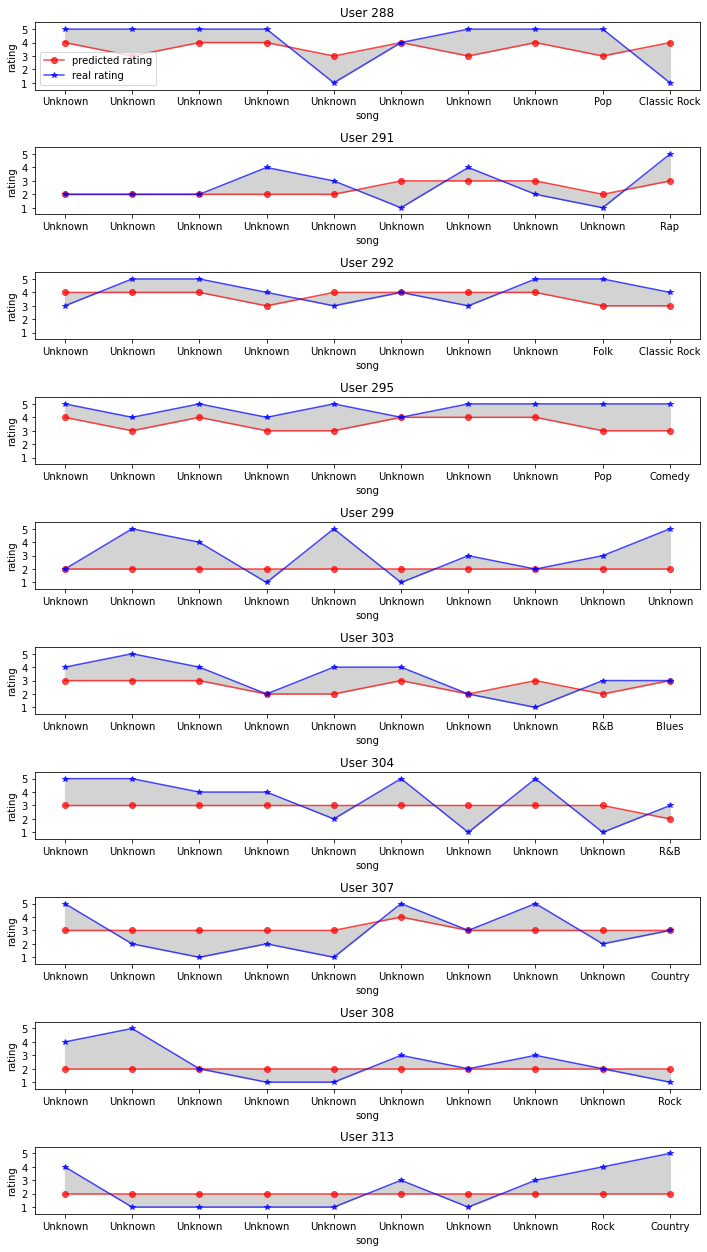

In [48]:
fig,axes=plt.subplots(nrows=n_users_vis,ncols=1,figsize=(10,n_users_vis*1.75))
xx=[i+1 for i in range(10)]
ind=0

for ax in axes:
    pred=ax.plot(xx,pred_r[ind],c='red',marker='o',label='predicted rating',alpha=.7)
    real=ax.plot(xx,rl_r[ind],c='blue',marker='*',label='real rating',alpha=.7)
    
    ax.fill_between(xx,pred_r[ind],rl_r[ind],color='lightgrey')

    ax.set_xlabel('song')
    ax.set_ylabel('rating')
    ax.set_title('User '+str(usrs10[ind+user_nr_switch]))
    ax.set_xticks(np.arange(1,11,1))
    ax.set_xticklabels(genres_vis[ind])
    ax.set_yticks(np.arange(1,6,1))
    ax.set_ylim(.5,5.5)
    ind+=1
    
axes[0].legend(handles=[pred[0],real[0]])
fig.set_tight_layout(True)

## IV. Recommending songs based on model's predictions

In [ ]:
# getting pairs (user_id, song_id) - all combinations of user-song that aren't in train set 
# (user ids and song ids are only from the train set)
testset = trainset_model_surprise.build_anti_testset()

In [50]:
testset2=[[] for i in range(data2['user_id'].nunique())]
for i in range(len(testset)):
    testset2[testset[i][0]].append([testset[i][0],testset[i][1]])

In [51]:
# predicting just for the user stated as the parameter instead of fitting to whole trainset, due to lower memory usage
def predict_ratings(user_id):
    user_pred=pd.DataFrame(columns=['song_id','predicted_rating'])
    # predict() function uses raw ids, so it's not needed to convert any ids since testset2 already contains raw ids
    for i in range(len(testset2[user_id])):
        user_pred.loc[i]=[testset2[user_id][i][1],svd.predict(testset2[user_id][i][0],testset2[user_id][i][1])[3]]
    user_pred.sort_values('predicted_rating',ascending=False,inplace=True)
    return user_pred

__This method is time consuming, as there are about 86k items to predict the stated user's ratings of__

In [52]:
user_pred0=predict_ratings(0) # getting df with predictions of ratings of the user

In [53]:
user_pred9=predict_ratings(9)

In [54]:
def get_top_n_songs(user_id,n,user_df):
    user_pred=user_df[:n]
    user_pred=user_pred.merge(data_songs,on='song_id')
    return user_pred

In [55]:
get_top_n_songs(0,10,user_pred0)

,song_id,predicted_rating,album_id,artist_id,genre_id
0,56649.0,4.925749,8174,3196,0
1,50008.0,4.909728,14425,4806,0
2,107521.0,4.905840,18140,575,0
3,32336.0,4.895809,10126,6328,114
4,38274.0,4.890472,4818,5508,0
5,109228.0,4.885717,11575,1855,134
6,100981.0,4.884770,11785,6755,0
7,115178.0,4.878992,12258,3265,0
8,128058.0,4.871681,1140,6011,0
9,76558.0,4.869005,19542,3586,0


In [56]:
get_top_n_songs(9,5,user_pred9)

,song_id,predicted_rating,album_id,artist_id,genre_id
0,115178.0,4.199389,12258,3265,0
1,38274.0,4.191112,4818,5508,0
2,85454.0,4.186082,6672,6961,0
3,55612.0,4.176017,19280,7111,0
4,46482.0,4.123231,913,9302,0


## V. Operations on similiar users

#### 1. Calculating similiar users
<br>Calculating most similiar users will be based on the smallest euclidean and cosine distances (two separate approaches) between users' vectors  created by SVD as a part of matrix factorization process.

In [57]:
user_vectors=svd.pu
len(user_vectors[0]) # = n_factors

20

Calculating euclidian and cosine distance in 20 dimensions shouldn't cause problems connected to the 'Curse Of Dimensionality'

In [58]:
# creating a list of dictionaries containing euclidian distances of a user to other users (for every user)
# getting top n similiar users (with the smallest distance)
distances_eu=[{} for i in range(data2['user_id'].nunique())]
distances_cos=[{} for i in range(data2['user_id'].nunique())]
similiar_users_eu=[[] for i in range(data2['user_id'].nunique())]
similiar_users_cos=[[] for i in range(data2['user_id'].nunique())]
n=5

for i in range(data2['user_id'].nunique()):
    for j in range(data2['user_id'].nunique()):
        if j!=i:
            distances_eu[i][j]=distance.euclidean(user_vectors[i],user_vectors[j])
            distances_cos[i][j]=distance.cosine(user_vectors[i],user_vectors[j])
    distances_eu[i]=dict(sorted(distances_eu[i].items(), key=lambda item: item[1]))
    distances_cos[i]=dict(sorted(distances_cos[i].items(), key=lambda item: item[1]))
    for k in range(n):
        similiar_users_eu[i].append(list(distances_eu[i].keys())[k])
        similiar_users_cos[i].append(list(distances_cos[i].keys())[k])

In [59]:
similiar_users_eu[0]

[668, 77, 263, 734, 147]

In [60]:
similiar_users_cos[0]

[206, 70, 197, 232, 77]

The first used metric for similiarity will be cosine distance

In [83]:
similiar_users=similiar_users_cos

#### 2. Taking a look at the model's performance from another perspective - loosely checking how metadata (in this example songs belonging to certain genres) has been decoded by the SVD model.
<br>It will be done by comparing most similiar users mean song ratings with respect to genres (from first and second levels of genres hierarchy trees).

In [62]:
df_info2=pd.merge(data_songs,data_genres,on=['genre_id'])
df_info2=df_info2[df_info2['genre_name']!='Unknown']
df_info2.reset_index(inplace=True)
df_info2.rename(columns={'index':'song_id'},inplace=True)
df_info2.head(3) # sorted by genre_name

,song_id,album_id,artist_id,genre_id,parent_genre_id,level,genre_name
0,118294,19512,7975,134,134,1,Rock
1,118295,16830,6857,134,134,1,Rock
2,118296,16565,2183,134,134,1,Rock


In [63]:
# Assigning genres from one level above to the songs belonging to genres being the leafs
# of the genres hirearchy trees (for more clearance in the next step)
for i in range(df_info2.shape[0]):
    if df_info2.iloc[i]['level']==3:
        df_info2.loc[i,'genre_name']=data_genres.iloc[df_info2.iloc[i]['parent_genre_id']]['genre_name']
        df_info2.loc[i,'level']=data_genres.iloc[df_info2.iloc[i]['parent_genre_id']]['level']
df_info2.drop(columns=['album_id','artist_id','genre_id','parent_genre_id','level'],inplace=True)

Comparison function

In [64]:
def sim_users_comparison(user_nr):
    neighbours=similiar_users[user_nr]
    
    def get_mean_ratings(user_nr):
        df_for_userx=data2[data2['user_id']==user_nr]
        df_info_userx=pd.merge(df_for_userx,df_info2,on='song_id')
        # removing rows with songs with unknown genre name
        df_info_userx=df_info_userx[df_info_userx['genre_name']!='Unknown']

        songs_genres=[[] for i in range(df_info_userx['genre_name'].nunique())] # how many genres has been rated by user

        for i in range(df_info_userx.shape[0]): # appending song ids to lists representing certain genres
            songs_genres[list(df_info_userx['genre_name'].unique()).index(df_info_userx.iloc[i]['genre_name'])].append(df_info_userx.iloc[i]['song_id'])

        songs_dict={}
        songs_count_dict={}
        for i in range(df_info_userx['genre_name'].nunique()):
            songs_dict[list(df_info_userx['genre_name'].unique())[i]]=songs_genres[i]
            songs_count_dict[list(df_info_userx['genre_name'].unique())[i]]=len(songs_genres[i])

        # df containing amount of songs from each genre that has been rated by the user
        songs_count_df=pd.DataFrame.from_dict(songs_count_dict,orient='index')
        songs_count_df.reset_index(inplace=True)
        songs_count_df.columns=['genre_name','song_count']
        songs_count_df=songs_count_df.sort_values('genre_name')
        songs_count_df.reset_index(inplace=True)
        songs_count_df.drop(columns=['index'],inplace=True)

        # df containing the mean rating for songs from each genre and the amount of them 
        df_info_userx=df_info_userx.groupby('genre_name').mean()
        df_info_userx.reset_index(inplace=True)
        df_info_userx['song_count']=songs_count_df['song_count']
        df_info_userx.drop(columns=['user_id','song_id'],inplace=True)
        df_info_userx=df_info_userx.sort_values('song_count',ascending=False)
        df_info_userx.reset_index(inplace=True)
        df_info_userx.drop(columns=['index'],inplace=True)
        
        return(df_info_userx,songs_dict)
    
    def get_shared_songs(neighbour_nr,main_user_dict,neighbour_dict):
        xdict=main_user_dict
        ydict=neighbour_dict

        shared_songs={}
        for x_genre in xdict:
            shared_songs[x_genre]=0
            for song in xdict[x_genre]:
                if x_genre in ydict.keys():
                    if song in ydict[x_genre]:
                        shared_songs[x_genre]+=1
        # df containing songs from each genre rated by both the user and his neighbour
        shared_songs_df=pd.DataFrame.from_dict(shared_songs,orient='index')    
        shared_songs_df.reset_index(inplace=True)
        shared_songs_df.columns=['genre_name','songs_shared']
        shared_songs_df=shared_songs_df.sort_values('genre_name',ascending=True)
                
        return shared_songs_df
    
    user_df=get_mean_ratings(user_nr)[0]
    
    n1=get_mean_ratings(neighbours[0])[0]
    n1=n1.sort_values('song_count',ascending=False)
    shared=get_shared_songs(neighbours[0],get_mean_ratings(user_nr)[1],get_mean_ratings(neighbours[0])[1])
    n1['songs_shared']=shared['songs_shared']
    
    n2=get_mean_ratings(neighbours[1])[0]
    n2=n2.sort_values('song_count',ascending=False)
    shared=get_shared_songs(neighbours[1],get_mean_ratings(user_nr)[1],get_mean_ratings(neighbours[1])[1])
    n2['songs_shared']=shared['songs_shared']
    
    return_df=pd.concat([user_df,n1,n2],axis=1)
    cols = pd.MultiIndex.from_tuples([('User '+str(user_nr), 'Genre name'), 
                                      ('User '+str(user_nr), 'Mean rating'),
                                      ('User '+str(user_nr), 'Song count'),
                                      ('First neighbour: User '+str(neighbours[0]), 'Genre name'),
                                      ('First neighbour: User '+str(neighbours[0]), 'Mean rating'),
                                      ('First neighbour: User '+str(neighbours[0]), 'Song count'),
                                      ('First neighbour: User '+str(neighbours[0]), 'Songs shared'),
                                      ('Second neighbour: User '+str(neighbours[1]), 'Genre name'),
                                      ('Second neighbour: User '+str(neighbours[1]), 'Mean rating'),
                                      ('Second neighbour: User '+str(neighbours[1]), 'Song count'),
                                      ('Second neighbour: User '+str(neighbours[1]), 'Songs shared')])
    return_df.columns=cols
    return_df.loc[:,('User '+str(user_nr),'Mean rating')]=return_df['User '+str(user_nr)]['Mean rating'].apply(lambda x: round(x,2) if np.isnan(x)==False else x)
    return_df.loc[:,('First neighbour: User '+str(neighbours[0]),'Mean rating')]=return_df['First neighbour: User '+str(neighbours[0])]['Mean rating'].apply(lambda x: round(x,2) if np.isnan(x)==False else x)
    return_df.loc[:,('Second neighbour: User '+str(neighbours[1]),'Mean rating')]=return_df['Second neighbour: User '+str(neighbours[1])]['Mean rating'].apply(lambda x: round(x,2) if np.isnan(x)==False else x)   

    return return_df

In [84]:
sim_users_comparison(0)

User 0                        First neighbour: User 206  \
         Genre name Mean rating Song count                Genre name   
0              Rock        3.67        3.0                      Rock   
1               R&B        5.00        2.0                       Pop   
2             Latin        4.00        1.0                       R&B   
3  Mainstream Dance        5.00        1.0                       Rap   
4               NaN         NaN        NaN        Adult Contemporary   
5               NaN         NaN        NaN               Classic R&B   
6               NaN         NaN        NaN              Classic Rock   
7               NaN         NaN        NaN                   Country   
8               NaN         NaN        NaN              Modern Blues   
9               NaN         NaN        NaN                    Reggae   

                                      Second neighbour: User 70              \
  Mean rating Song count Songs shared                Genre name Mean rating   
0        3.29          7          0.0                      Rock         4.5   
1        3.60          5          0.0                       Pop         4.0   
2        5.00          2          0.0               Classic R&B         5.0   
3        3.50          2          0.0                    Comedy         5.0   
4        2.00          1          NaN                Indie Rock         4.0   
5        3.00          1          NaN                      Jazz         2.0   
6        3.00          1          NaN                     Latin         5.0   
7        4.00          1          NaN                       Rap         3.0   
8        1.00          1          NaN                       NaN         NaN   
9        5.00          1          NaN                       NaN         NaN   

                           
  Song count Songs shared  
0        4.0          0.0  
1        3.0          0.0  
2        1.0          0.0  
3        1.0          0.0  
4        1.0          NaN  
5        1.0          NaN  
6        1.0          NaN  
7        1.0          NaN  
8        NaN          NaN  
9        NaN          NaN

In [89]:
sim_users_comparison(15)

User 15                        First neighbour: User 614  \
            Genre name Mean rating Song count                Genre name   
0                 Rock         2.0         12                      Rock   
1                  Pop         2.4          5                       Pop   
2                  R&B         1.0          3              Classic Rock   
3   Adult Contemporary         1.0          1                       R&B   
4                Blues         1.0          1                   Country   
5         Classic Rock         2.0          1          Mainstream Dance   
6               Comedy         4.0          1                       NaN   
7              Country         5.0          1                       NaN   
8                 Folk         5.0          1                       NaN   
9                 Jazz         4.0          1                       NaN   
10    Mainstream Dance         2.0          1                       NaN   
11               Metal         1.0          1                       NaN   
12                 Rap         1.0          1                       NaN   

                                       Second neighbour: User 571              \
   Mean rating Song count Songs shared                 Genre name Mean rating   
0         2.33       12.0          0.0                       Rock        2.25   
1         2.75        8.0          0.0                        R&B        1.64   
2         2.00        2.0          0.0                        Pop        1.88   
3         2.50        2.0          0.0               Classic Rock        2.33   
4         2.00        1.0          0.0                       Jazz        1.00   
5         2.00        1.0          0.0                    Country        2.50   
6          NaN        NaN          NaN                        Rap        2.00   
7          NaN        NaN          NaN                Classic R&B        1.00   
8          NaN        NaN          NaN                     Comedy        2.00   
9          NaN        NaN          NaN           Electronic/Dance        2.00   
10         NaN        NaN          NaN                      Metal        1.00   
11         NaN        NaN          NaN                        NaN         NaN   
12         NaN        NaN          NaN                        NaN         NaN   

                            
   Song count Songs shared  
0        16.0          2.0  
1        11.0          0.0  
2         8.0          0.0  
3         3.0          0.0  
4         3.0          0.0  
5         2.0          0.0  
6         2.0          0.0  
7         1.0          0.0  
8         1.0          0.0  
9         1.0          0.0  
10        1.0          0.0  
11        NaN          NaN  
12        NaN          NaN

Now the euclidian distance will be used

In [91]:
similiar_users=similiar_users_eu

In [92]:
sim_users_comparison(0)

User 0                        First neighbour: User 668  \
          Genre name Mean rating Song count                Genre name   
0               Rock        3.67        3.0                      Rock   
1                R&B        5.00        2.0                       R&B   
2              Latin        4.00        1.0                       Pop   
3   Mainstream Dance        5.00        1.0                      Folk   
4                NaN         NaN        NaN                 Christmas   
5                NaN         NaN        NaN               Classic R&B   
6                NaN         NaN        NaN                    Comedy   
7                NaN         NaN        NaN                   Country   
8                NaN         NaN        NaN                       Rap   
13               NaN         NaN        NaN                     Latin   
16               NaN         NaN        NaN              Classic Rock   
15               NaN         NaN        NaN            Easy Listening   
14               NaN         NaN        NaN        Adult Contemporary   
9                NaN         NaN        NaN         Adult Alternative   
12               NaN         NaN        NaN          Mainstream Dance   
11               NaN         NaN        NaN                      Jazz   
10               NaN         NaN        NaN                     Metal   
17               NaN         NaN        NaN                  Soft Pop   

                                       Second neighbour: User 77              \
   Mean rating Song count Songs shared                Genre name Mean rating   
0         3.83         23          0.0                      Rock        4.54   
1         3.33          6          0.0                       Pop        4.67   
2         3.20          5          0.0                       R&B        4.71   
3         3.00          3          0.0                   Country        4.67   
4         2.50          2          NaN                       Rap        5.00   
5         4.00          2          NaN              Classic Rock        5.00   
6         4.50          2          NaN                      Folk        5.00   
7         4.00          2          NaN                      Jazz        5.00   
8         3.50          2          NaN                     Latin        5.00   
13        3.00          1          NaN                       NaN         NaN   
16        4.00          1          NaN                       NaN         NaN   
15        4.00          1          NaN                       NaN         NaN   
14        4.00          1          NaN                       NaN         NaN   
9         4.00          1          NaN          Mainstream Dance        3.00   
12        4.00          1          NaN                       NaN         NaN   
11        4.00          1          NaN                       NaN         NaN   
10        4.00          1          NaN                    Reggae        5.00   
17        4.00          1          NaN                       NaN         NaN   

                            
   Song count Songs shared  
0        13.0          0.0  
1         9.0          0.0  
2         7.0          0.0  
3         3.0          0.0  
4         2.0          NaN  
5         1.0          NaN  
6         1.0          NaN  
7         1.0          NaN  
8         1.0          NaN  
13        NaN          NaN  
16        NaN          NaN  
15        NaN          NaN  
14        NaN          NaN  
9         1.0          NaN  
12        NaN          NaN  
11        NaN          NaN  
10        1.0          NaN  
17        NaN          NaN

In [93]:
sim_users_comparison(15)

User 15                        First neighbour: User 614  \
            Genre name Mean rating Song count                Genre name   
0                 Rock         2.0         12                      Rock   
1                  Pop         2.4          5                       Pop   
2                  R&B         1.0          3              Classic Rock   
3   Adult Contemporary         1.0          1                       R&B   
4                Blues         1.0          1                   Country   
5         Classic Rock         2.0          1          Mainstream Dance   
6               Comedy         4.0          1                       NaN   
7              Country         5.0          1                       NaN   
8                 Folk         5.0          1                       NaN   
9                 Jazz         4.0          1                       NaN   
10    Mainstream Dance         2.0          1                       NaN   
11               Metal         1.0          1                       NaN   
12                 Rap         1.0          1                       NaN   

                                       Second neighbour: User 268              \
   Mean rating Song count Songs shared                 Genre name Mean rating   
0         2.33       12.0          0.0                       Rock         5.0   
1         2.75        8.0          0.0                        R&B         5.0   
2         2.00        2.0          0.0                    Ambient         5.0   
3         2.50        2.0          0.0                    Country         5.0   
4         2.00        1.0          0.0                 Indie Rock         5.0   
5         2.00        1.0          0.0                        NaN         NaN   
6          NaN        NaN          NaN                        NaN         NaN   
7          NaN        NaN          NaN                        NaN         NaN   
8          NaN        NaN          NaN                        NaN         NaN   
9          NaN        NaN          NaN                        NaN         NaN   
10         NaN        NaN          NaN                        NaN         NaN   
11         NaN        NaN          NaN                        NaN         NaN   
12         NaN        NaN          NaN                        NaN         NaN   

                            
   Song count Songs shared  
0         3.0          0.0  
1         2.0          0.0  
2         1.0          0.0  
3         1.0          0.0  
4         1.0          0.0  
5         NaN          NaN  
6         NaN          NaN  
7         NaN          NaN  
8         NaN          NaN  
9         NaN          NaN  
10        NaN          NaN  
11        NaN          NaN  
12        NaN          NaN

The imbalance concerning the amount of genre instances in the dataset makes the results here less interesting. There are also some users rating songs f.e. only very high or very low, which makes it harder for the model to discern the factors concerning song genres.
<br>It's problematic to make any assumptions based on above presented data, but it could be said that song genres might have been vaguely decoded by the model.

#### 2. Comparing similiar users (SVD) and neighbours (kNN Baseline)

In [75]:
for i in range(3):
    print('Neighbours for user',i,
          '\n kNN:', knn.get_neighbors(i,5),
          '\n SVD (cosine):',similiar_users_cos[i],
          '\n SVD (euclidian):', similiar_users_eu[i])
    print()

Neighbours for user 0 
 kNN: [144, 375, 286, 292, 132] 
 SVD (cosine): [206, 70, 197, 232, 77] 
 SVD (euclidian): [668, 77, 263, 734, 147]

Neighbours for user 1 
 kNN: [128, 88, 204, 424, 51] 
 SVD (cosine): [79, 324, 519, 450, 122] 
 SVD (euclidian): [324, 519, 79, 238, 668]

Neighbours for user 2 
 kNN: [36, 20, 63, 128, 115] 
 SVD (cosine): [383, 531, 723, 539, 593] 
 SVD (euclidian): [43, 741, 489, 485, 226]



## VI. Music genres graphs

In [76]:
def edges(genre_id,parent_id,level):
    edges=[]
    colors=[]
    for i in range(len(genre_id)):
        if level[i]>1:
            edges.append((parent_id[i],genre_id[i]))
            if level[i]==2:
                colors.append('#f2ae72')
            elif level[i]==3:
                colors.append('#f2e394')
        else: colors.append('#d96459')  
    return edges, colors

In [77]:
node_colors=edges(list(data_genres.index),list(data_genres['parent_genre_id']),list(data_genres['level']))[1]
edges=edges(list(data_genres.index),list(data_genres['parent_genre_id']),list(data_genres['level']))[0]

net = Network(notebook=True,height='750px',width='1000px')

net.add_nodes(list(data_genres.index),
             label=list(data_genres['genre_name']),
             color=node_colors)

net.add_edges(edges)

net.show('genre-graph.html')

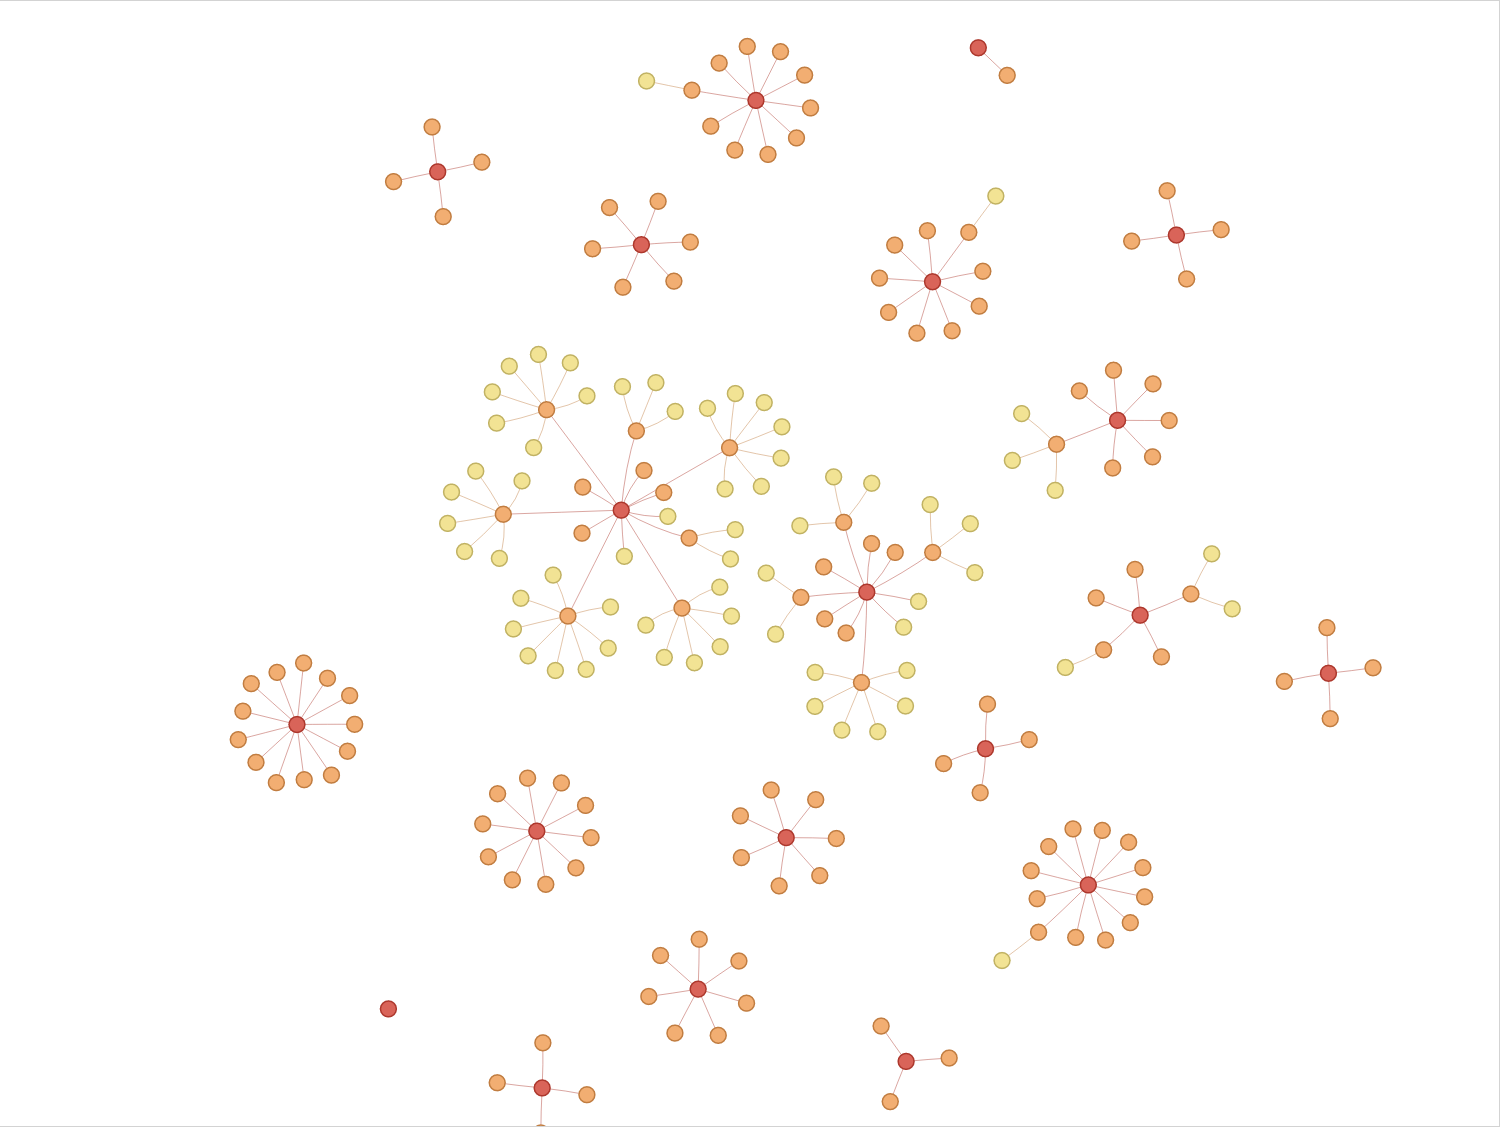

In [94]:
from IPython.display import Image
Image("graph1.png")

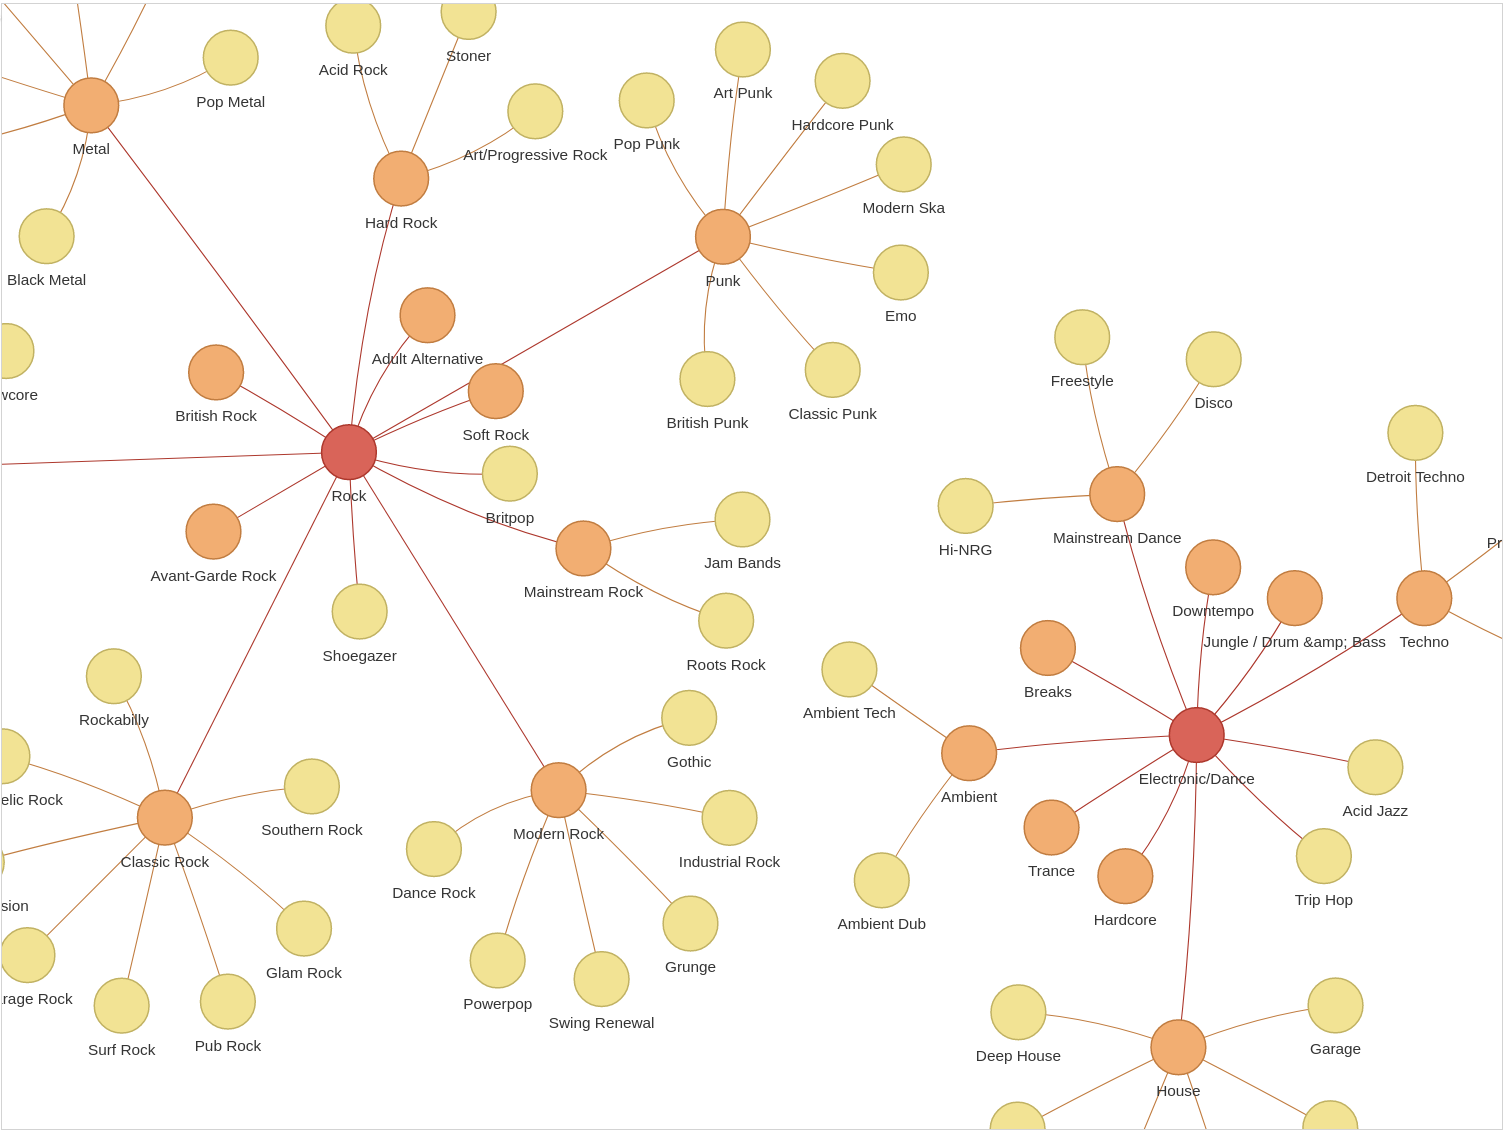

In [95]:
Image("graph2.png")

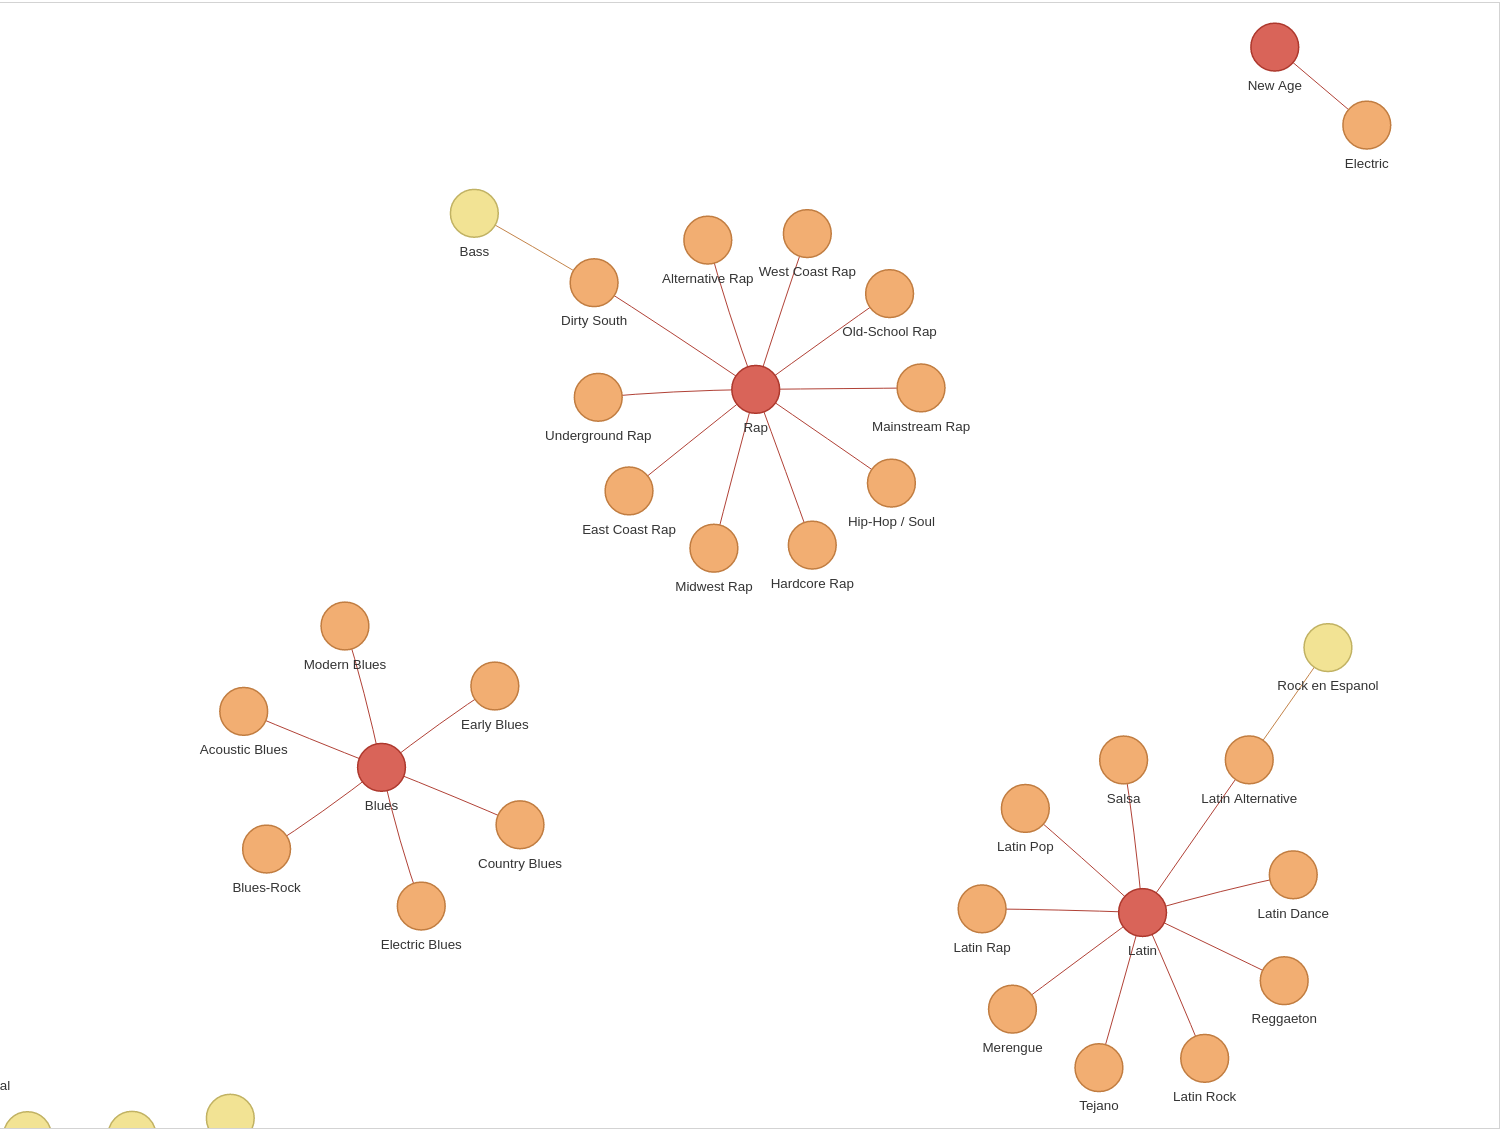

In [96]:
Image("graph3.png")